# Artificial Lift - Gas Lift Design
**Objective:** Optimize production by calculating the required Gas Injection Rate ($q_{inj}$).

**Author:** Ade Anggi Naluriawan Santoso

**The Principle:**
Gas Lift works by injecting high-pressure gas into the tubing. This mixes with the reservoir fluid, reducing the mixture density ($\rho_{mix}$).
* **Lower Density** $\rightarrow$ **Lower Hydrostatic Pressure Drop**
* **Lower $P_{wf}$** $\rightarrow$ **Higher Drawdown** $\rightarrow$ **Higher Inflow**

**The Trade-off:**
* **Too little gas:** Fluid remains heavy, $P_{wf}$ is high, rate is low.
* **Too much gas:** Friction increases rapidly (gas velocity is high), causing $P_{wf}$ to rise again, killing the rate.

In this notebook, we will generate a **Gas Lift Performance Curve** to find the sweet spot.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Modified TPR for Gas Lift
We need to modify our pressure gradient function to account for **Total GLR**.

$$GLR_{total} = GLR_{formation} + GLR_{injected}$$

$$GLR_{inj} = \frac{q_{gas\_inj}}{q_{liquid}}$$

We will reuse the simplified TPR logic from the previous notebook but expose `glr` as a variable input.

In [2]:
def get_tpr_pressure_gaslift(q_liq, glr_total, p_wh, depth, tubing_id):
    """
    Calculates Required Bottomhole Pressure (Pwf) given a Total GLR.
    """
    # 1. Hydrostatic Component
    # Gas Lift reduces gradient significantly.
    # We use a simplified correlation: Grad decreases as GLR increases.
    # Base gradient ~0.35 psi/ft (liquid), decays with gas.
    
    decay_factor = np.exp(-0.0005 * glr_total) # Simplified physics for demo
    grad_elev = 0.05 + 0.30 * decay_factor
    
    p_hydro = depth * grad_elev
    
    # 2. Friction Component
    # Friction INCREASES with GLR because gas velocity is high.
    # We add a GLR term to the friction coefficient.
    
    friction_term = (q_liq ** 2) * (1 + 0.002 * glr_total) 
    C = 2.0e-5
    p_friction = C * friction_term * (depth / 1000) / (tubing_id ** 5)
    
    return p_wh + p_hydro + p_friction

## 2. The Gas Lift Solver
For a specific **Injection Rate ($q_{inj}$)**, we need to find the equilibrium production rate.

**Algorithm:**
1. Choose an Injection Rate (e.g., 500 Mscf/d).
2. Guess a Liquid Rate ($q_{liq}$).
3. Calculate Total GLR: $GLR_{tot} = R_s + (q_{inj} / q_{liq})$.
4. Calculate Supply Pressure ($P_{ipr}$) and Demand Pressure ($P_{tpr}$).
5. Find where they equal.

In [3]:
# Import IPR function from previous logic (re-defined here for standalone running)
def get_ipr_pressure(q, p_res, q_max):
    if q >= q_max: return 0.0
    if q <= 0: return p_res
    y = q / q_max
    return p_res * ((-0.2 + np.sqrt(0.2**2 - 4*0.8*(y-1))) / 1.6)

def solve_gas_lift_rate(q_inj_scfd, well_data):
    """
    Finds the liquid production rate for a given Gas Injection Rate.
    """
    p_res = well_data['p_res']
    q_max = well_data['q_max']
    p_wh = well_data['p_wh']
    depth = well_data['depth']
    tid = well_data['tubing_id']
    glr_res = well_data['glr_formation'] # Formation GLR (scf/stb)
    
    def residual(q_liq):
        if q_liq <= 1: return p_res # Prevent div by zero
        
        # Calculate Total GLR for this specific liquid rate assumption
        # GLR_total = Formation Gas + Injected Gas
        # Note: Injected Gas Ratio changes as q_liq changes!
        glr_total = glr_res + (q_inj_scfd / q_liq)
        
        supply = get_ipr_pressure(q_liq, p_res, q_max)
        demand = get_tpr_pressure_gaslift(q_liq, glr_total, p_wh, depth, tid)
        
        return supply - demand

    # Solve for Flow Rate
    try:
        # Check if well is dead even with lift (at low rates)
        if residual(10) < 0: return 0.0
        
        q_sol = brentq(residual, 10, q_max)
        return q_sol
    except:
        return 0.0

## 3. Performance Curve Optimization
Now we run the solver for a range of **Injection Rates** to find the maximum possible oil production.

**Scenario:**
* **Well Depth:** 8000 ft
* **Reservoir Pressure:** 3000 psia
* **Productivity ($q_{max}$):** 5000 stb/d
* **Formation GLR:** 200 scf/stb (Low energy, well might be dead naturally)

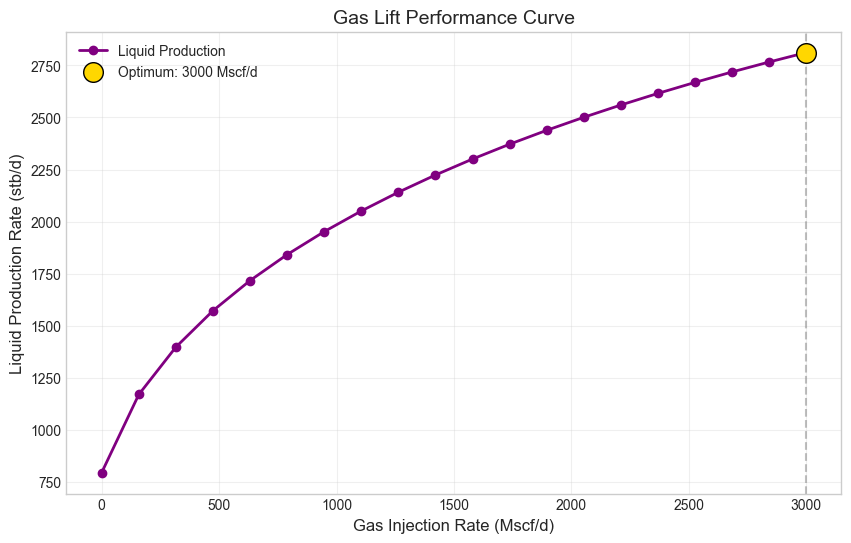

In [4]:
# --- WELL DATA ---
well_data = {
    'p_res': 3000,
    'q_max': 5000,
    'p_wh': 150,
    'depth': 8000,
    'tubing_id': 2.441,
    'glr_formation': 200 # scf/stb
}

# --- GENERATE PERFORMANCE CURVE ---
injection_rates = np.linspace(0, 3000000, 20) # 0 to 3 MMscf/d
production_rates = []

for q_inj in injection_rates:
    q_out = solve_gas_lift_rate(q_inj/1000.0, well_data) # Function expects scf/d not MMscf/d? 
    # Let's fix units: Pass raw SCFD.
    q_out = solve_gas_lift_rate(q_inj, well_data)
    production_rates.append(q_out)

# --- FIND OPTIMUM ---
max_prod = max(production_rates)
opt_inj_idx = production_rates.index(max_prod)
opt_inj = injection_rates[opt_inj_idx]

# --- PLOTTING ---
plt.figure(figsize=(10, 6))

plt.plot(injection_rates / 1000, production_rates, marker='o', color='purple', linewidth=2, label='Liquid Production')

# Highlight Optimum
plt.scatter(opt_inj/1000, max_prod, s=200, color='gold', edgecolors='black', zorder=10, label=f'Optimum: {opt_inj/1000:.0f} Mscf/d')

plt.title("Gas Lift Performance Curve", fontsize=14)
plt.xlabel("Gas Injection Rate (Mscf/d)", fontsize=12)
plt.ylabel("Liquid Production Rate (stb/d)", fontsize=12)
plt.axvline(opt_inj/1000, color='gray', linestyle='--', alpha=0.5)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Interpretation
Look at the curve generated above:

1.  **Slope Up (The Lift Effect):** Initially, injecting gas reduces the hydrostatic weight. Production rises sharply.
2.  **Peak (Optimum):** The point where the benefit of lightening the fluid equals the penalty of increased friction.
3.  **Slope Down (Friction Dominated):** Injecting more gas past the peak increases velocity so much that friction prevents flow. This is called "choking" the tubing with gas.

**Economic Limit:**
In reality, the optimum is slightly to the *left* of the peak, because compressing gas costs money. You want the point where:
$$\frac{\Delta Oil}{\Delta Gas} = \frac{Cost_{Gas}}{Price_{Oil}}$$